# Baseline Model
This notebook is meant to apply the most basic data preprocessing techniques to examine if data fusion can help increase the model performance on healthy/impairedCog/AD-Dementia prediction task. The preprocessing steps includes mean/mode imputation, PCA feature dimension reduction, and logistic regression. Notice that in order to "fuse" the other data sources (mri and csf), we conducted an inner join. For example, to check the effects of MRI on UDS data source, we found people with both UDS and MRI records and fit logistic regressions on UDS and UDS+MRI separately. Since few people were recorded in all three data sources, fusing altogether is challenging. 

Future direction:
- Variable Missing Imputation: KNN, RF
- Dimension Reduction: PCA, Group Lasso, AutoEncoder
- Counterfactual data generation: VAE (other generating model maybe)
- Prediction: Group Lasso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
import os, sys

sys.path.append(os.path.join("../", "utils"))
import load_data

In [2]:
reload(load_data)
uds = load_data.load_uds()
mri = load_data.load_mri()
csf = load_data.load_csf()
csf = csf.drop(['CSFTTYR', 'CSFLPMO', 'CSFLPDY', 'CSFABMO', 'CSFABDY', 'CSFABYR',
                'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFLPYR',
                'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
uds_dict, mri_dict = load_data.load_feature_map()
print(uds.shape, mri.shape, csf.shape)

# uds.to_csv("../data/data_cleaned/uds.csv", index = False)
# mri.to_csv("../data/data_cleaned/mri.csv", index = False)
# csf.to_csv("../data/data_cleaned/csf.csv", index = False)

(45100, 94) (11273, 170) (3017, 8)


# Data Preprocessing
## Drop missing
- drop features has more than 50% ppl missing
- drop individuals has more than 50% MRI features missing

## Impute Missing
- Mean and mode

In [3]:
## Drop missing
# - drop features has more than 50% ppl missing
# - drop individuals has more than 50% MRI features missing

# RF imputation for UDS and MRi
# uds = pd.read_csv("../data/data_cleaned/uds_rf.csv")
# mri = pd.read_csv("../data/data_cleaned/mri_rf.csv")

def drop_missing(df, row_thres=0.5, col_thres=0.5):
    df = df.loc[df.isna().mean(axis=1)<row_thres, df.isna().mean(axis=0)<col_thres]
    return df

# uds = drop_missing(uds)
# mri = drop_missing(mri, col_thres=0.6) # a lot of missing, 11k -> 4.5k
csf = drop_missing(csf, col_thres=0.8)

# Impute missing with column mean (numeric) or mode (categorical)
def impute_missing(df):
    for c in df.columns:
        try:
            if c not in ['NACCID', 'datetime', 'NACCUDSD']:
                if df[c].nunique() <= 20:
                    df[c] = df[c].fillna(value = df[c].mode().values[-1])
                else:
                    df[c] = df[c].fillna(value = df[c].mean())
        except:
            print("Cannot convert column ", c)
    return df

uds = impute_missing(uds)
mri = impute_missing(mri)
csf = impute_missing(csf)

uds = uds.dropna(subset=['NACCUDSD', 'EDUC'])
print(Counter(uds['NACCUDSD']))

uds.loc[uds['NACCUDSD']==2, 'NACCUDSD']=1
uds = uds.drop('NACCVNUM', axis=1)
print(Counter(mri.groupby(['NACCID', 'NACCVNUM'])['datetime'].count().values)) # each patient may have multiple MRI 
mri = mri.sort_values(['NACCID', 'datetime']).groupby("NACCID").first().reset_index() # Only keep the first record, 4.5k->2.8k
print(uds.shape, mri.shape, csf.shape)

Cannot convert column  FRONTGRY
Cannot convert column  FRONTWHT
Cannot convert column  FRONTCSF
Cannot convert column  OCCIPGRY
Cannot convert column  OCCIPWHT
Cannot convert column  OCCIPCSF
Cannot convert column  PARGRY
Cannot convert column  PARWHT
Cannot convert column  PARCSF
Cannot convert column  TEMPGRY
Cannot convert column  TEMPWHT
Cannot convert column  TEMPCSF
Counter({1: 17772, 4: 15483, 3: 9852, 2: 1993})
Counter({1: 9129, 2: 482, 3: 146, 4: 46, 6: 28, 5: 22, 7: 11, 9: 9, 10: 6, 8: 5, 11: 2})
(45100, 93) (7328, 170) (2868, 8)


# PCA feature dimension reduction

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = None

def pca_transform(df, var_dict, n_component, pca_thres = 0.8):
    global pca
    pca = PCA(n_components=n_component)
    to_ret = pd.DataFrame()
    for cat in var_dict['Category'].unique():
        if cat != 'DEMO':
            var_names = var_dict[var_dict['Category'] == cat]['VariableName'].values
            var_names = set(var_names).intersection(set(df.columns))
            if len(var_names) > n_component:
                pca_transformed = pca.fit_transform(scaler.fit_transform(df.loc[:,var_names]))
                num_selected_1 = np.sum(pca.explained_variance_ratio_ > pca_thres)
                num_selected_2 = np.argmax(-np.diff(pca.explained_variance_ratio_, n=1) > 0.1) + 1
                num_selected = max(num_selected_1, num_selected_2)
                temp = pd.DataFrame(pca_transformed[:,:num_selected])
                temp.columns = ["{}_{}".format(cat, i+1) for i in range(num_selected)]
                print(cat, pca.explained_variance_ratio_, num_selected)
                to_ret = pd.concat([to_ret, temp], axis=1)
    return to_ret

CDF [0.76895493 0.1085716  0.03648204 0.03119127 0.01719705] 1
GDS [0.34199268 0.07280743 0.06836063 0.05803149 0.05448806] 1
FAS [0.75336689 0.05854651 0.04165502 0.03227832 0.02868984] 1
NPI [0.27971299 0.07271375 0.07079298 0.05935407 0.04910833] 1
NEURO [0.2725585  0.1670008  0.06720314 0.05821838 0.05499608] 1
(45100, 13)


<AxesSubplot:>

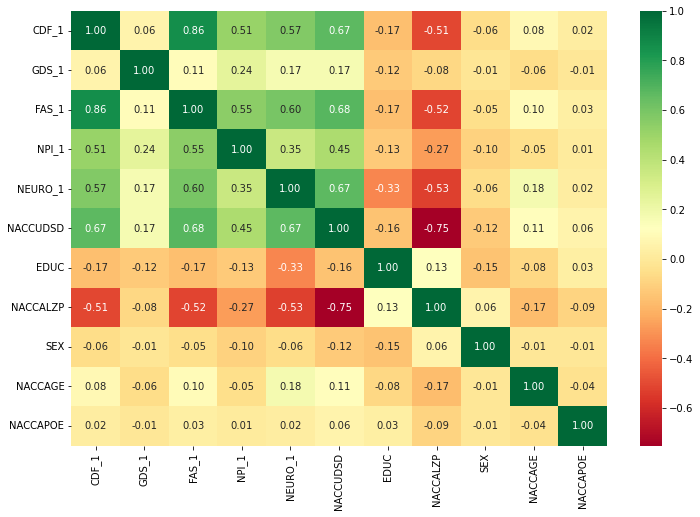

In [5]:
# PCA UDS  UDS is unique for each patient at baseline
assert(len(Counter(uds.groupby('NACCID')['datetime'].count().values)))
uds_pca = pca_transform(uds.drop(['NACCID', 'NACCUDSD', 'NACCADC'], axis=1), uds_dict, 5, pca_thres=0.2)
demo_features = set(uds.columns).intersection(set(uds_dict[uds_dict['Category'] == 'DEMO']['VariableName'].values))
uds_pca = pd.concat([uds_pca, uds[demo_features - set(['NACCADC'])].reset_index(drop=True)], axis=1)
uds_pca['NACCID'] = uds.reset_index()['NACCID']
uds_pca['datetime'] = uds.reset_index()['datetime']
print(uds_pca.shape)

plt.figure(figsize = (12,8))
sns.heatmap(uds_pca.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

Regional gray matter volumes [0.56278366 0.1731543  0.06220701 0.0489356  0.03457377] 2
Regional cortical thicknesses [0.44472966 0.05129374 0.0377714  0.03155449 0.02452773] 1
PET scan data [0.37911734 0.13163995 0.07767074 0.05634387 0.03521895] 2
(7328, 18)


<AxesSubplot:>

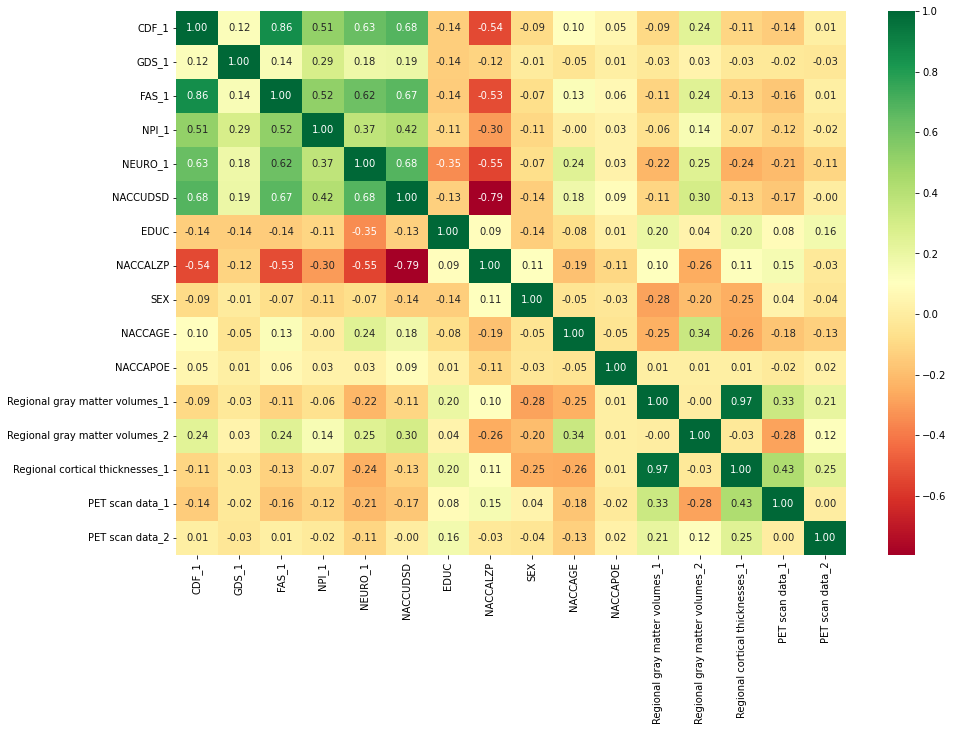

In [6]:
#  PCA MRI data 
assert(len(Counter(mri.groupby('NACCID')['datetime'].count().values)))
mri_pca = pca_transform(mri.drop(['NACCID', 'datetime'], axis=1), mri_dict, 5, pca_thres=0.1)
mri_pca['NACCID'] = mri.reset_index()['NACCID']
uds_mri_merged = uds_pca.merge(mri_pca, on='NACCID', how='inner')
print(uds_mri_merged.shape)

plt.figure(figsize = (15, 10))
sns.heatmap(uds_mri_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

[0.57272228 0.42313746]
(414, 20)


<AxesSubplot:>

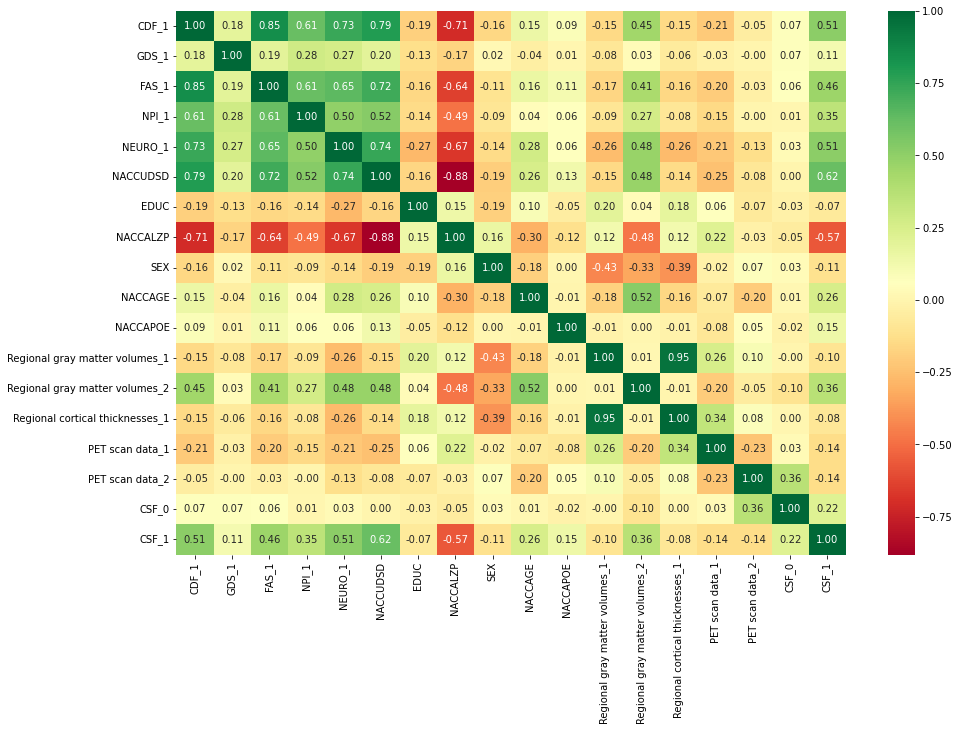

In [7]:
# CSF-patient, duplicates exist for some individuals - should keep the MD features?
csf = csf.groupby('NACCID').mean().reset_index()
# csf_var = csf.drop("NACCADC", axis=1).describe().columns
pca = PCA(n_components=2)
csf_pca = pca.fit_transform(csf.drop(['NACCID', 'NACCADC'], axis=1))
print(pca.explained_variance_ratio_)

csf_pca = pd.DataFrame(csf_pca[:,:2])
csf_pca.columns = ['CSF_{}'.format(i) for i in range(csf_pca.shape[1])]
csf_pca['NACCID'] = csf.reset_index()['NACCID']
uds_mri_cfs_merged = uds_mri_merged.merge(csf_pca, on='NACCID', how='inner')
print(uds_mri_cfs_merged.shape)

plt.figure(figsize = (15, 10))
sns.heatmap(uds_mri_cfs_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def print_summary(clf, Xtr, ytr, Xte, yte):
    print("Training Score:  ")
    print(metrics.confusion_matrix(ytr, clf.predict(Xtr)))
    print(metrics.accuracy_score(ytr, clf.predict(Xtr)))
    print()
    print("Testing Score:  ")
    print(metrics.confusion_matrix(yte, clf.predict(Xte)))
    print(metrics.accuracy_score(yte, clf.predict(Xte)))

# UDS Only

In [9]:
print(uds_pca.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)

X_train, X_test, y_train, y_test = train_test_split(uds_pca.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                     uds_pca['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(45100, 13) 

Training Score:  
[[12828   985   122]
 [ 2178  3842   866]
 [   99  1077  9573]]
0.8312638580931264

Testing Score:  
[[5374  413   43]
 [ 917 1672  377]
 [  51  467 4216]]
0.8323725055432373


# UDS v.s. UDS + MRI

## - UDS-Sub

In [10]:
uds_sub = uds_pca[uds_pca['NACCID'].isin(uds_mri_merged['NACCID'])]
print(uds_sub.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)

X_train, X_test, y_train, y_test = train_test_split(uds_sub.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_sub['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(7328, 13) 

Training Score:  
[[2471  200   10]
 [ 376  912  108]
 [   2  168  882]]
0.8315461103528953

Testing Score:  
[[1079   86    3]
 [ 159  335   52]
 [   4   73  408]]
0.8285584356525694


## - UDS + MRI

In [11]:
print(uds_mri_merged.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)

X_train, X_test, y_train, y_test = train_test_split(uds_mri_merged.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_mri_merged['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(7328, 18) 

Training Score:  
[[2476  195   10]
 [ 377  908  111]
 [   2  161  889]]
0.8331058685903685

Testing Score:  
[[1080   85    3]
 [ 159  335   52]
 [   3   71  411]]
0.8303774442928604


# UDS + MRI + CSF
## - UDS-sub

In [12]:
uds_sub = uds_pca[uds_pca['NACCID'].isin(uds_mri_cfs_merged['NACCID'])]
print(uds_sub.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(uds_sub.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_sub['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(414, 13) 

Training Score:  
[[152   3   1]
 [ 15  37   5]
 [  2   5  69]]
0.8927335640138409

Testing Score:  
[[75  3  0]
 [ 4 11  7]
 [ 0  6 19]]
0.84


/home/hanweny/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## - UDS + MRI

In [13]:
uds_mri_sub = uds_mri_merged[uds_mri_merged['NACCID'].isin(uds_mri_cfs_merged['NACCID'])]
print(uds_mri_sub.shape,'\n')
clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(uds_mri_sub.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_mri_sub['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(414, 18) 

Training Score:  
[[152   3   1]
 [ 15  38   4]
 [  1   7  68]]
0.8927335640138409

Testing Score:  
[[73  5  0]
 [ 5 12  5]
 [ 0  6 19]]
0.832


/home/hanweny/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## - UDS + MRI + CSF

In [14]:
print(uds_mri_cfs_merged.shape,'\n')

clf = LogisticRegression(random_state=48, max_iter=1000, solver='saga', penalty='elasticnet', C=0.4, l1_ratio=0.3)
X_train, X_test, y_train, y_test = train_test_split(uds_mri_cfs_merged.drop(['NACCID', 'NACCALZP', 'NACCUDSD', 'datetime'], axis=1), 
                                                    uds_mri_cfs_merged['NACCUDSD'], test_size = 0.3, random_state=48)
clf = clf.fit(X_train, y_train)
print_summary(clf, X_train, y_train, X_test, y_test)

(414, 20) 

Training Score:  
[[149   5   2]
 [ 27  11  19]
 [  3   5  68]]
0.7889273356401384

Testing Score:  
[[76  2  0]
 [11  2  9]
 [ 2  2 21]]
0.792


/home/hanweny/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
